## AI Anomaly Detection in Cybersecurity Network Logs

### 1.Problem statement

- The goal of this project is to build an AI-driven anomaly detection system that identifies unusual or potentially malicious activity in network traffic using the UNSW-NB15 cybersecurity dataset. By applying unsupervised machine learning methods such as Isolation Forest and Autoencoders, the model learns normal network behavior and flags deviations that may indicate cyber threats or intrusions.
This project demonstrates how machine learning can enhance network security and threat detection by analyzing high-dimensional network log data.

### 2.Data Collection

- UNSW-NB15 Data : https://research.unsw.edu.au/projects/unsw-nb15-dataset

### 2.1 Import Data and Required Packages

Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Import the CSV Data as Pandas DataFrame

In [3]:
df = pd.read_csv("../data/UNSW_NB15_training-set.csv")

Show Top 5 Records

In [4]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


### 2.2 Dataset information

Shape of the dataset

In [5]:
df.shape

(175341, 45)

Features - 45

In [6]:
df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

### 3. Data Checks and Data Cleaning

### 3.1 Check Missing values

In [7]:
df.isna().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

There is no null values in the dataset

### 3.2 Check Duplicates

In [8]:
df.duplicated().sum()

np.int64(0)

There are no duplicates values in the dataset

### 3.3 Check data types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

### 3.4 Check unique values in categorical columns

In [10]:
df['proto'].value_counts()

proto
tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
          ...  
argus        98
netblt       98
igmp         18
icmp         15
rtp           1
Name: count, Length: 133, dtype: int64

In [11]:
df['service'].value_counts()

service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: count, dtype: int64

Replacing '-' with 'unknown' in 'service' column

In [12]:
df['service']=df["service"].replace('-','unknown', regex=True)

In [13]:
df['state'].value_counts()

state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
URN        1
no         1
Name: count, dtype: int64

In [14]:
df['attack_cat'].value_counts()

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

In [15]:
df['label'].value_counts()

label
1    119341
0     56000
Name: count, dtype: int64

### 3.5 Basic Numeric Statistics

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,175341.0,8.767100e+04,5.061673e+04,1.0,43836.000000,87671.000000,1.315060e+05,1.753410e+05
dur,175341.0,1.359389e+00,6.480249e+00,0.0,0.000008,0.001582,6.680690e-01,5.999999e+01
spkts,175341.0,2.029866e+01,1.368876e+02,1.0,2.000000,2.000000,1.200000e+01,9.616000e+03
dpkts,175341.0,1.896959e+01,1.102583e+02,0.0,0.000000,2.000000,1.000000e+01,1.097400e+04
sbytes,175341.0,8.844844e+03,1.747656e+05,28.0,114.000000,430.000000,1.418000e+03,1.296523e+07
dbytes,175341.0,1.492892e+04,1.436542e+05,0.0,0.000000,164.000000,1.102000e+03,1.465555e+07
rate,175341.0,9.540619e+04,1.654010e+05,0.0,32.786140,3225.806520,1.250000e+05,1.000000e+06
sttl,175341.0,1.795470e+02,1.029400e+02,0.0,62.000000,254.000000,2.540000e+02,2.550000e+02
dttl,175341.0,7.960957e+01,1.105069e+02,0.0,0.000000,29.000000,2.520000e+02,2.540000e+02
sload,175341.0,7.345403e+07,1.883574e+08,0.0,13053.338870,879674.750000,8.888889e+07,5.988000e+09


### 3.6 Distribution of labels

In [20]:
df['label'].value_counts(normalize=True)

label
1    0.680622
0    0.319378
Name: proportion, dtype: float64

Dataset is imbalanced

### 3.7 Check for constant columns

In [25]:
df.nunique().sort_values().head(15)

is_sm_ips_ports      2
label                2
is_ftp_login         4
ct_ftp_cmd           4
ct_state_ttl         5
dttl                 6
dwin                 7
state                9
attack_cat          10
sttl                11
ct_flw_http_mthd    11
trans_depth         11
swin                13
service             13
ct_dst_sport_ltm    32
dtype: int64

### 3.8 Look for suspicious or zero-heavy columns

In [23]:
(df == 0).sum().sort_values(ascending=False).head(10)

is_ftp_login         172774
ct_ftp_cmd           172774
is_sm_ips_ports      172579
response_body_len    164047
trans_depth          157501
ct_flw_http_mthd     157501
dloss                 96637
ackdat                96301
tcprtt                96300
synack                96300
dtype: int64

### 3.9 Dropping unnecessary columns

In [24]:
df.drop(columns='id', inplace=True)

#### Initial Data Exploration

- The dataset contains 175341 rows and 45 columns.
- Numeric columns describe packet statistics, bytes, jitter, TTL values, load, flows, etc.
- Categorical columns include: proto, service, state, and attack_cat.
- service contains 13 unique values.
- No major missing values, but some categorical values need normalization (e.g., replacing '-' with 'unknown').
- The target label (label) is imbalanced: approx 32% normal and 68% attack.
- Some columns are highly skewed (e.g., duration, bytes), which requires scaling before modeling.

### 4. Exploring Data ( Visualization )

#### 4.1 Label Distribution (Normal vs Attack)

In [27]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (8,5)

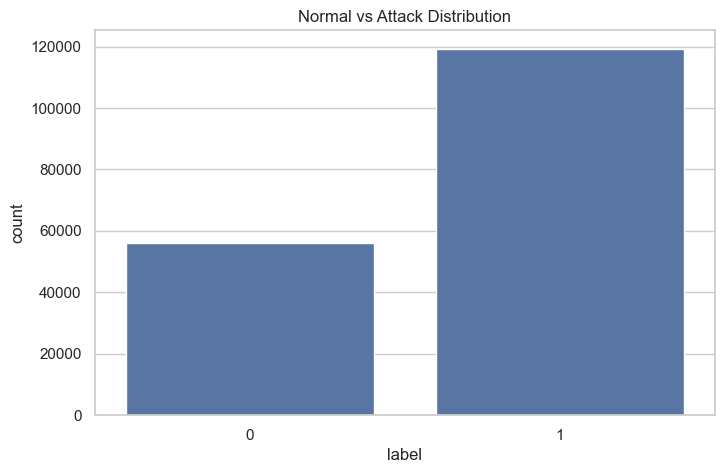

In [28]:
sns.countplot(x='label', data=df)
plt.title('Normal vs Attack Distribution')
plt.show()

Dataset is balanced

#### 4.2 Attack Category Distribution

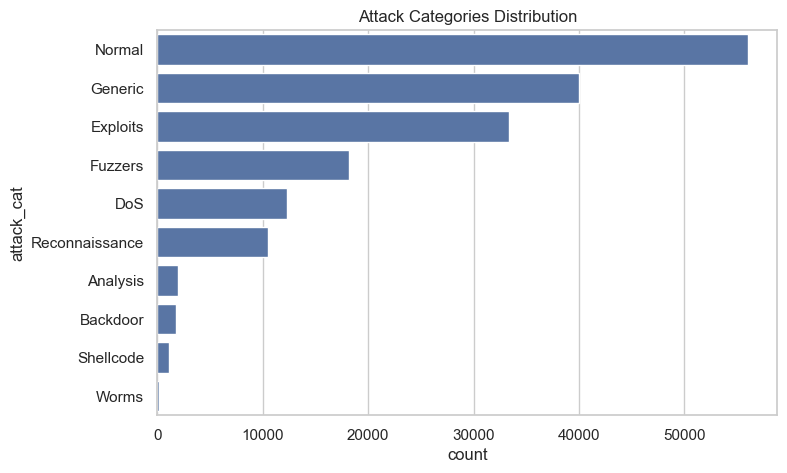

In [29]:
sns.countplot(y='attack_cat', data=df, order=df['attack_cat'].value_counts().index)
plt.title('Attack Categories Distribution')
plt.show()

- Generic, Exploits, Fuzzers - these attack types are dominant
- Severe imbalance across attack types.

#### 4.3 Protocol Distribution (proto)

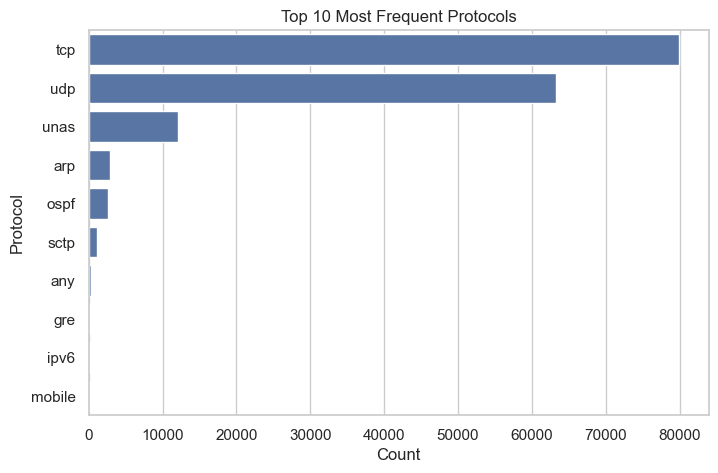

In [30]:
top_protos = df['proto'].value_counts().head(10)

sns.barplot(x=top_protos.values, y=top_protos.index)
plt.title("Top 10 Most Frequent Protocols")
plt.xlabel("Count")
plt.ylabel("Protocol")
plt.show()

- TCP and UDP dominates

#### 4.4 Service Distribution

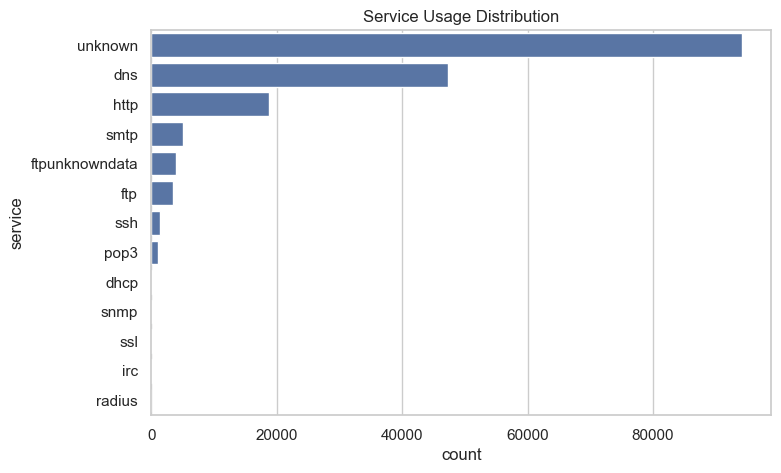

In [31]:
sns.countplot(y='service', data=df, order=df['service'].value_counts().index)
plt.title('Service Usage Distribution')
plt.show()

#### 4.5. Correlation Heatmap (Top 15 Features)

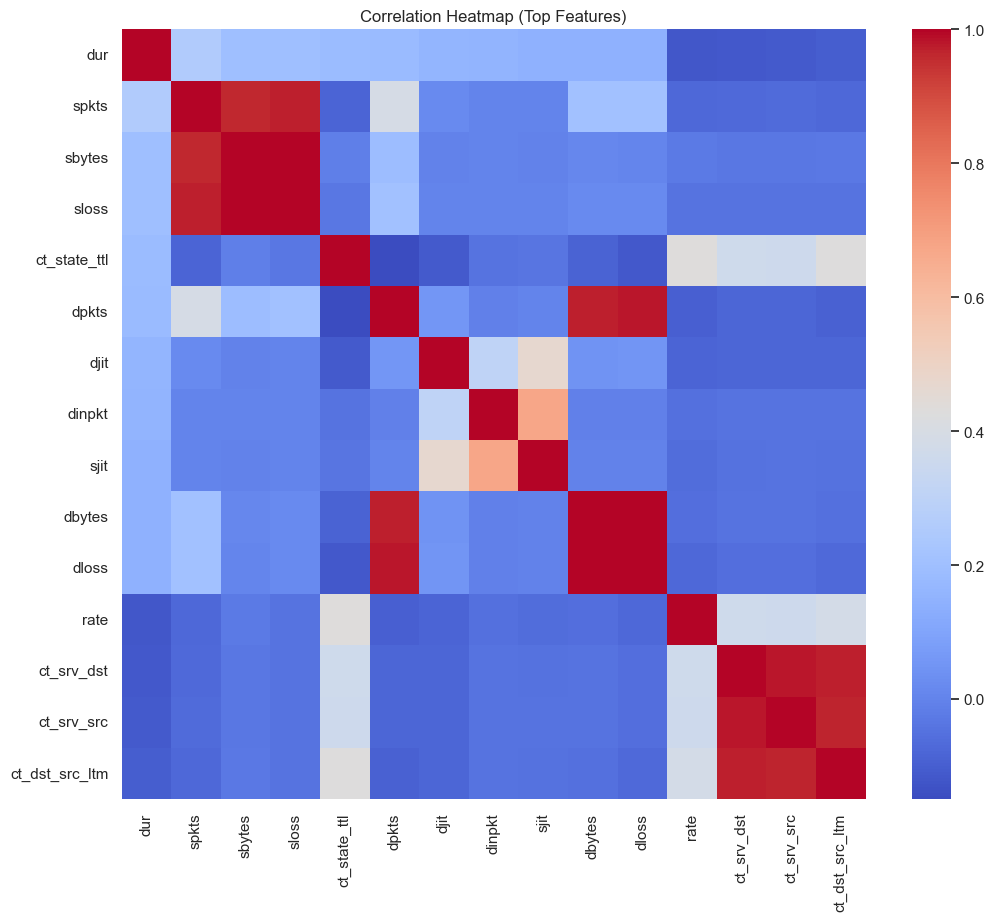

In [32]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
top_corr = numeric_df.corr().abs().nlargest(15, 'dur').index  # picking top correlated with 'dur' or any reference
corr = numeric_df[top_corr].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Top Features)')
plt.show()

#### 4.6 Distribution of Key Numeric Features

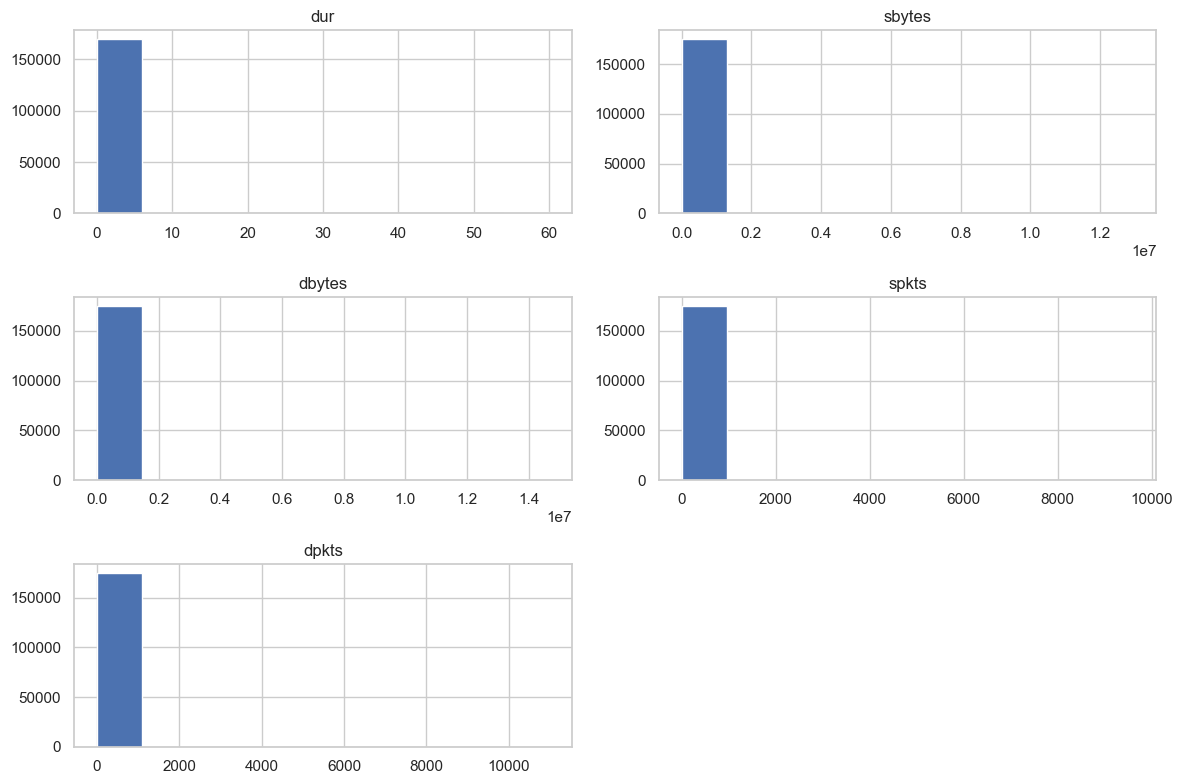

In [33]:
cols_to_plot = ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts']
df[cols_to_plot].hist(figsize=(12,8))
plt.tight_layout()
plt.show()

These features ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts'] have long-tail distributions:

- 98–99% of values are VERY small
- a few values are EXTREMELY large (outliers)

#### 4.7 Boxplots to Detect Outliers

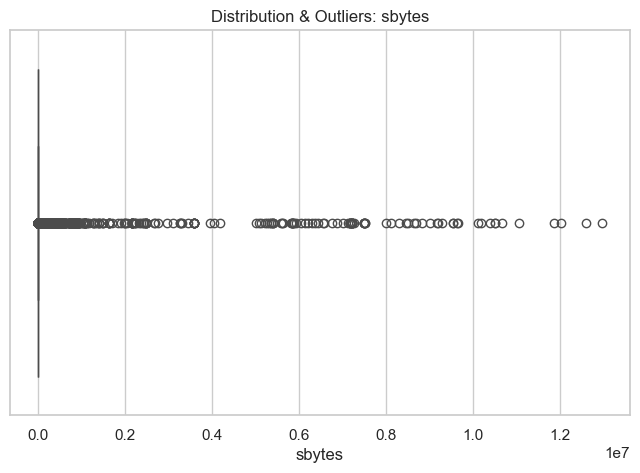

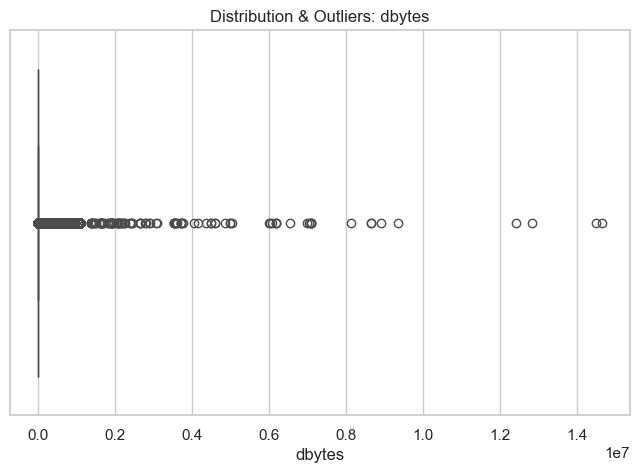

In [34]:
sns.boxplot(x=df['sbytes'])
plt.title('Distribution & Outliers: sbytes')
plt.show()

sns.boxplot(x=df['dbytes'])
plt.title('Distribution & Outliers: dbytes')
plt.show()

- Lots of extreme outliers (Isolation Forest will detect these!)

#### 4.8 Pairplot for Attack vs Normal

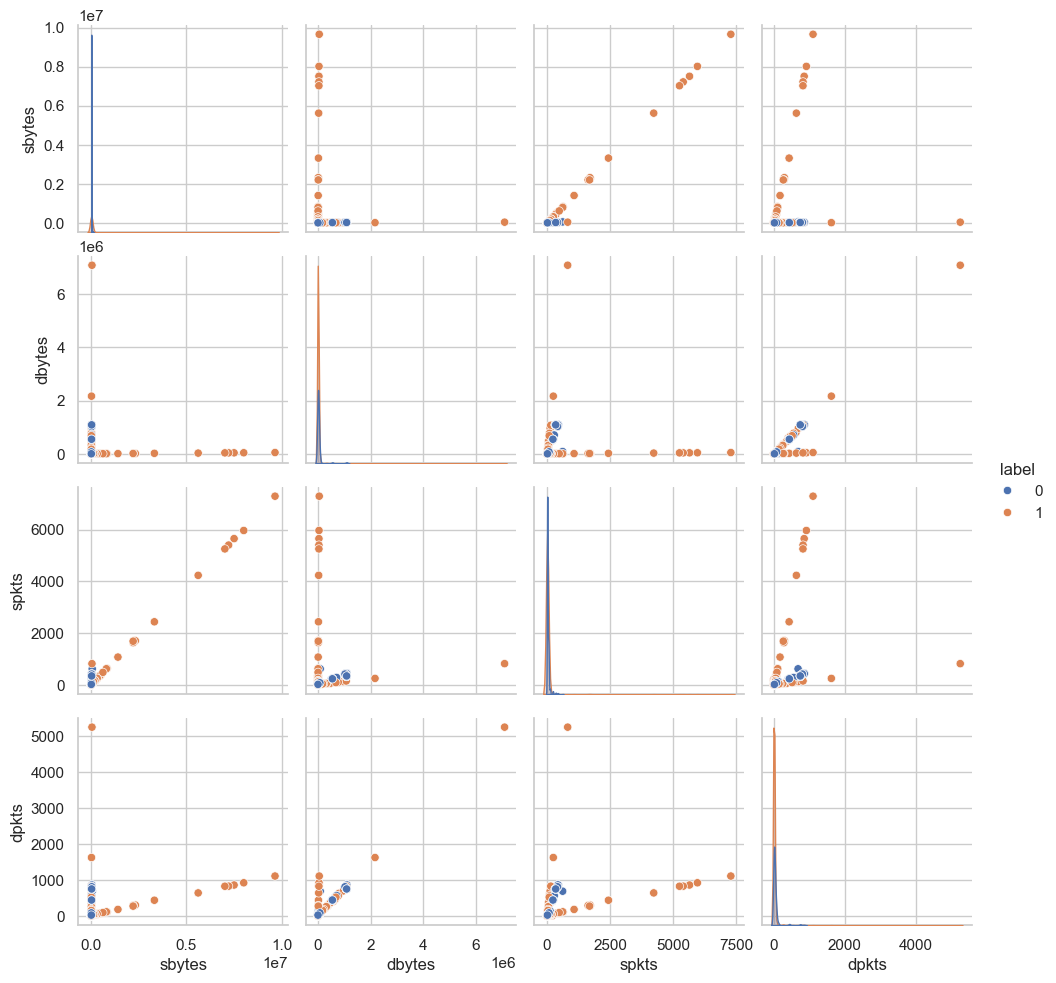

In [35]:
sample = df.sample(5000, random_state=42)

sns.pairplot(sample, vars=['sbytes','dbytes','spkts','dpkts'], hue='label')
plt.show()

#### EDA Summary

- The dataset is imbalanced, with more traffic being attacks (label 1).
- Certain attack types dominate (Generic, Exploits), leading to skewed class distribution.
- Key network features such as sbytes, dbytes, spkts, and dpkts show heavy skewness and many outliers — suitable for anomaly detection.
- Protocol and service distributions show realistic network patterns.
- Correlation analysis reveals strong relationships between packet- and byte-related features.
- Overall, the dataset contains rich network metadata appropriate for building anomaly detection models.